Референс:
https://arxiv.org/pdf/2207.11771

In [ ]:
import torch

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchsummary import summary
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets

In [ ]:
MNIST_train=torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test=torchvision.datasets.MNIST('./', download = True, train = False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 33629389.23it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1413716.29it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 11857568.74it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9492042.24it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Автокодировщик для удаления шума

In [ ]:
#X_train.targets

In [ ]:
X_train = MNIST_train.train_data/255
X_test = MNIST_test.train_data/255

noise = 0.5 #чем выше значение, тем более зашумленные данные

X_train_noise = X_train + noise * np.random.normal(loc = 0, scale=1 ,size = X_train.shape)
X_test_noise = X_test + noise * np.random.normal(loc = 0, scale=1 ,size = X_test.shape)

X_train=X_train.to(torch.float32) #данные без шума
X_test=X_test.to(torch.float32)

X_train_noise=X_train_noise.to(torch.float32) #данные с шумом для проверки работы автокодировщика
X_test_noise=X_test_noise.to(torch.float32)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Данные с шумом мы используем для входа в сеть, а данные без шума - для оценки качества результата

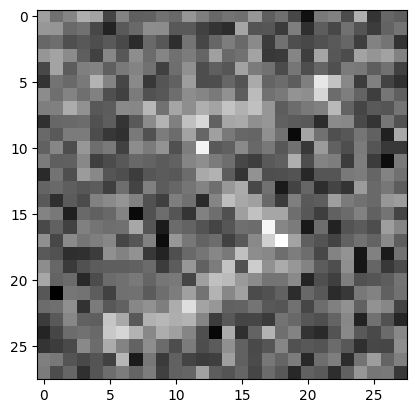

In [ ]:
plt.imshow(X_train_noise[0], cmap='gray')

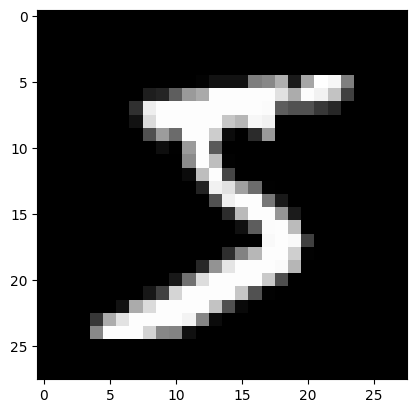

In [ ]:
plt.imshow(X_train[0], cmap='gray')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1,padding=1)
      self.act1 = torch.nn.ReLU()
      self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
      self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1,padding=1)
      self.act2 = torch.nn.ReLU()
      self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):
      #print("Start", x.size())
      x = self.act1(self.conv1(x))
      #print("Conv1",x.size())
      x = self.pool1(x)
      #print("pool",x.size())
      x = self.act2(self.conv2(x))
      #print('conv2', x.size())
      x = self.pool2(x)
      #print("pool",x.size())


      return x


In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self):
      super().__init__()
      #размерность выход энкодера должна совпадать размерностью входа декодера

      self.deconv1 = torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2,stride=2)
      self.act1 = torch.nn.ReLU()
      self.deconv2 = torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2,stride=2)
      self.act2 = torch.nn.ReLU()
      self.conv = torch.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3,stride=1,padding=1)
      self.act3 = torch.nn.Sigmoid() # А ПОЧЕМУ??

    def forward(self, x):

      #print("Start", x.size())
      x = self.act1(self.deconv1(x))
      #print("deconv1",x.size())
      x = self.act3(self.deconv2(x))
      #print("deconv1",x.size())
      x = self.act3(self.conv(x))
      #print("conv",x.size())

      return x


In [ ]:
def train_ae(data_loader, encoder, decoder, epochs, lr):
    encoder.train()
    decoder.train()
    print('Обучение автокодировщика..')

    loss_func = torch.nn.MSELoss()#функция потерь
    optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)#оптимизатор
    loss_history = list()
    for epoch in range(epochs):
        #i = 0
        for (batch, val) in data_loader:
            #batch -- это данные с шумом
            #val -- данные без шума

            optimizer.zero_grad()
            #plt.imshow(batch.to(torch.device('cpu')).detach().numpy()[0], cmap='gray')
            #plt.show()
            #plt.imshow(decoder(encoder(batch)).to(torch.device('cpu')).detach().numpy()[0], cmap='gray')
            #plt.show()

            loss = loss_func(decoder(encoder(batch)), val)#посчитать ошибку
            loss.backward()
            optimizer.step()

            loss_history.append(loss.log().item())
            #print(i)
            #i += 1
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')
        plt.plot(loss_history)

    print('Готово!')

    encoder.eval()
    decoder.eval()

    plt.plot(loss_history)
    plt.show()

In [ ]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

In [ ]:
#сделать даталоадер, в котором будут данные с шумом для обучения и таргеты - данные без шума

In [ ]:
X_train_noise, X_train = X_train_noise.to(device), X_train.to(device)
zip(X_train_noise, X_train)

In [ ]:
train_data_loader = DataLoader([*zip(X_train_noise[:5000], X_train[:5000])], shuffle=True)#????
#train_data_loader = train_data_loader.to(device)

Обучение автокодировщика..
Эпоха 1 / 8. Потери на последнем пакете: 0.02988554909825325
Эпоха 2 / 8. Потери на последнем пакете: 0.015345284715294838
Эпоха 3 / 8. Потери на последнем пакете: 0.01700524240732193
Эпоха 4 / 8. Потери на последнем пакете: 0.007974949665367603
Эпоха 5 / 8. Потери на последнем пакете: 0.007083285599946976
Эпоха 6 / 8. Потери на последнем пакете: 0.0094101307913661
Эпоха 7 / 8. Потери на последнем пакете: 0.015326287597417831
Эпоха 8 / 8. Потери на последнем пакете: 0.008290505036711693
Готово!


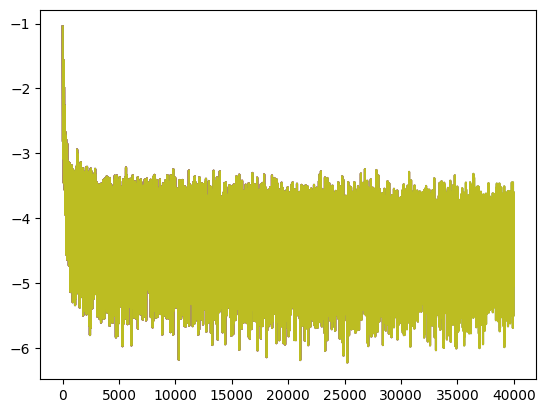

In [ ]:
EPOCHS= 8#кол-во эпох
LR= 0.001#скорость обучения
train_ae(train_data_loader, encoder, decoder, EPOCHS, LR)
#train_ae([*zip(train_data_loader, target)], encoder, decoder, EPOCHS, LR)

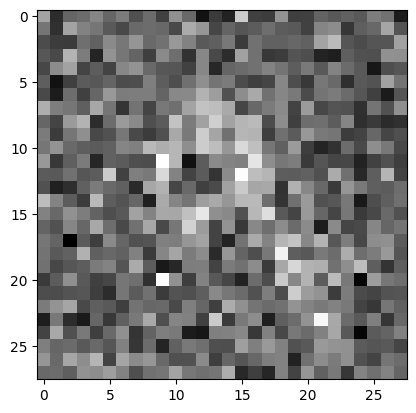

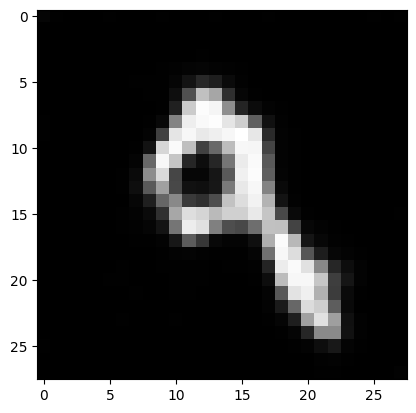

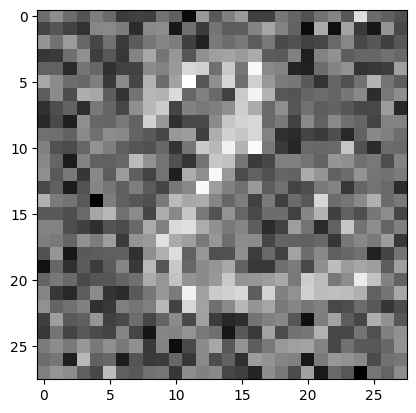

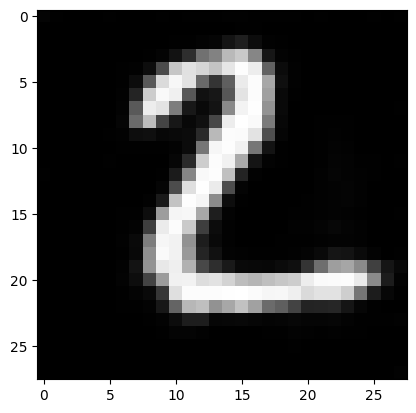

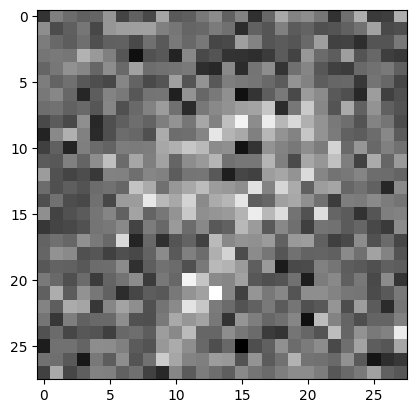

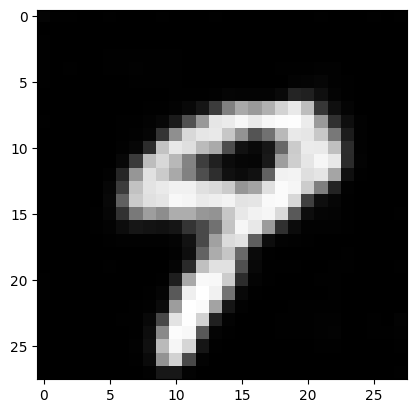

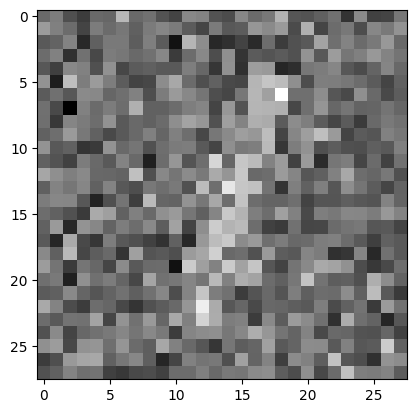

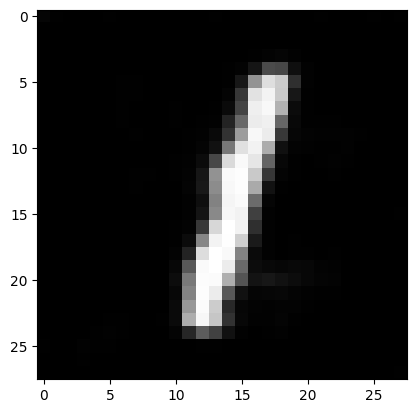

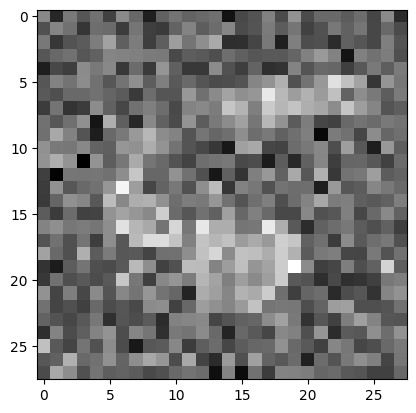

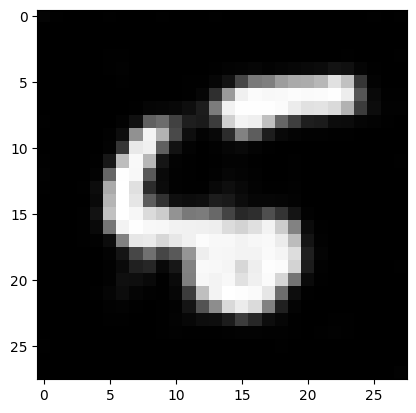

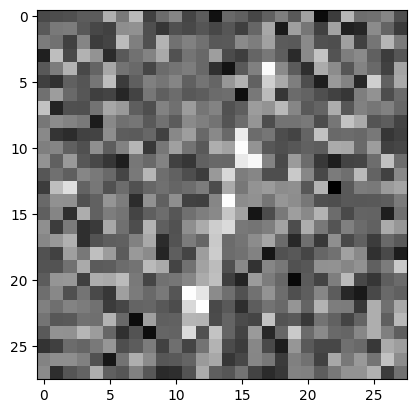

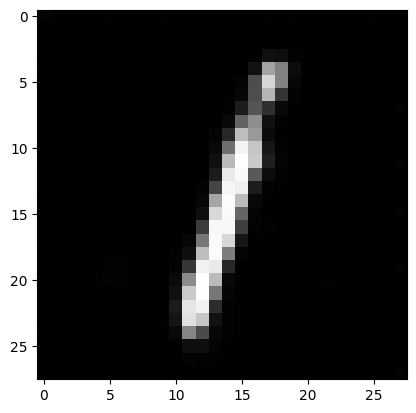

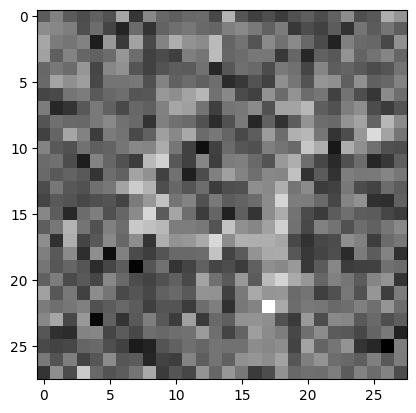

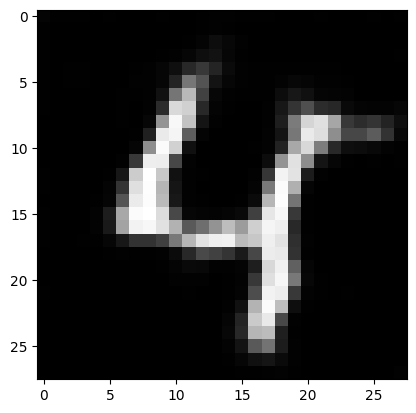

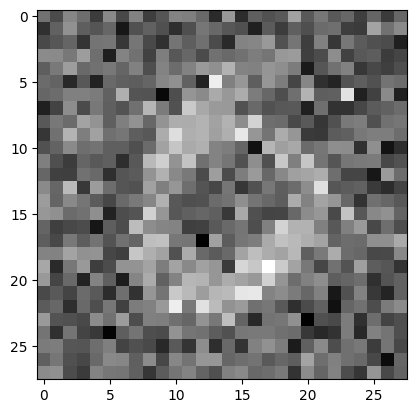

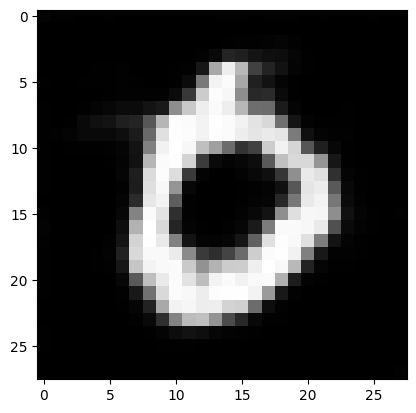

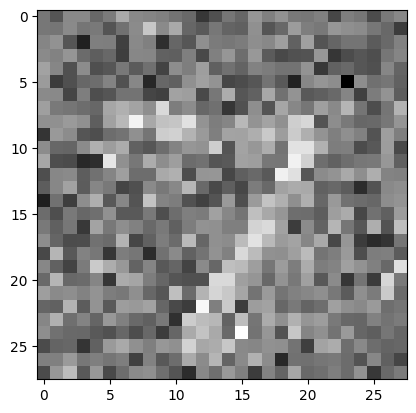

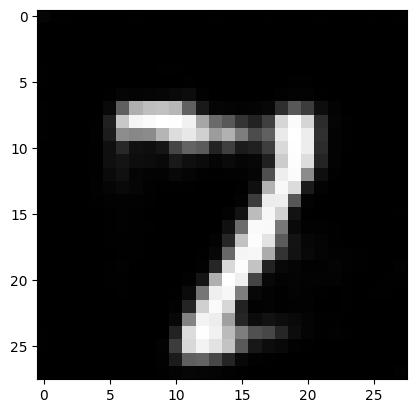

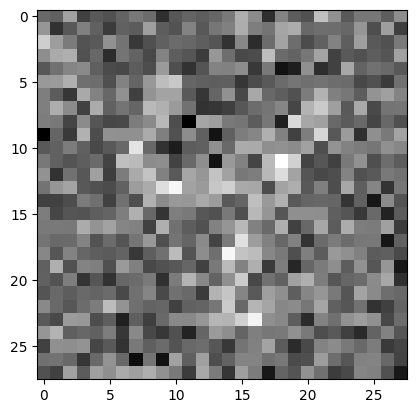

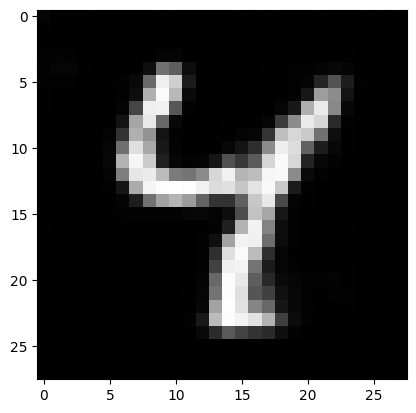

In [ ]:
X_test_noise, X_test = X_test_noise.to(device), X_test.to(device)
test_data_loader = DataLoader([*zip(X_test_noise[:10], X_test[:10])], shuffle=True)#????
for (batch, val) in test_data_loader:
  plt.imshow(batch.to(torch.device('cpu')).detach().numpy()[0], cmap='gray')
  plt.show()
  plt.imshow(decoder(encoder(batch)).to(torch.device('cpu')).detach().numpy()[0], cmap='gray')
  plt.show()